In [21]:
import fitz  # PyMuPDF for PDF handling
from PIL import Image, ImageDraw, ImageFont  # Image processing
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from Crypto.Util.Padding import pad
import base64
import os
from IPython.display import display
import json

In [22]:
def pdf_to_images(pdf_path, num_pages=2):
    pdf_document = fitz.open(pdf_path)
    images = []
    for page_num in range(min(num_pages, pdf_document.page_count)):
        page = pdf_document[page_num]
        pix = page.get_pixmap()  # Render page as pixel map
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        images.append(img)
    pdf_document.close()
    return images

📄 Page 1 with bounding boxes (saved at text_boxes_images\text_boxes_page_1.png)


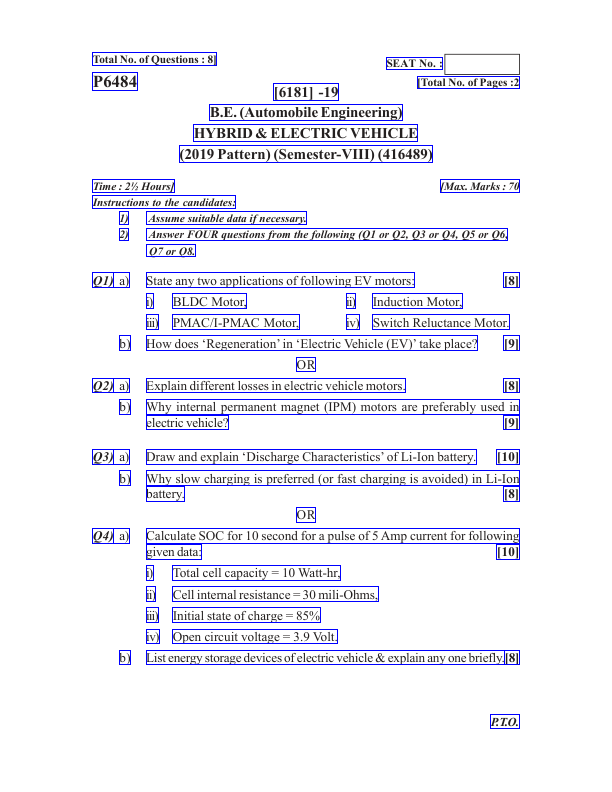

📄 Page 2 with bounding boxes (saved at text_boxes_images\text_boxes_page_2.png)


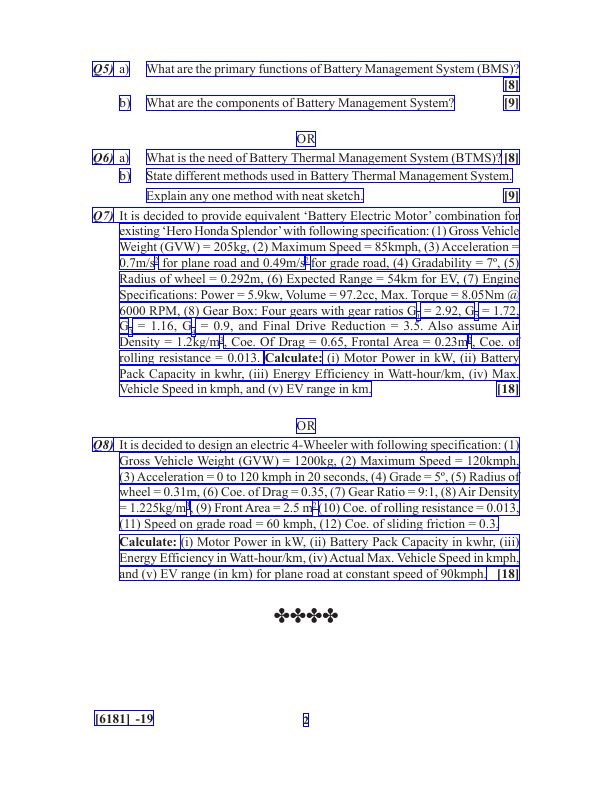

[[(92.6405258178711, 52.83171081542969, 216.865966796875, 65.31855010986328, 'Total No. of Questions : 8]'), (273.6028137207031, 83.47560119628906, 338.4026184082031, 100.08055877685547, '[6181] -19'), (209.7577667236328, 104.11518859863281, 402.4022521972656, 120.72014617919922, 'B.E. (Automobile Engineering)'), (193.79832458496094, 124.87198638916016, 417.9877014160156, 141.47694396972656, 'HYBRID & ELECTRIC VEHICLE'), (179.39894104003906, 145.63609313964844, 432.6432800292969, 162.2410430908203, '(2019 Pattern) (Semester-VIII) (416489)'), (92.6405258178711, 179.54873657226562, 174.3407745361328, 192.03558349609375, 'Time : 2½ Hours]'), (440.1740417480469, 179.54873657226562, 519.35888671875, 192.03558349609375, '[Max. Marks : 70'), (92.6405258178711, 195.7470703125, 235.92892456054688, 208.23391723632812, 'Instructions to the candidates:'), (119.28156280517578, 211.9453887939453, 128.45211791992188, 224.43223571777344, '1)'), (146.01490783691406, 211.9453887939453, 306.8661804199219

In [23]:
import os
import fitz  # PyMuPDF
from PIL import Image, ImageDraw
from IPython.display import display

def get_text_boxwise_and_show_boxes(pdf_path, min_pages=1, max_pages=5, output_dir="text_boxes_images"):
    pdf_document = fitz.open(pdf_path)
    all_text_boxes = []

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Make sure we process between min_pages and max_pages, within the available page count
    total_pages = pdf_document.page_count
    pages_to_process = max(min(total_pages, max_pages), min_pages)

    for page_num in range(pages_to_process):
        page = pdf_document[page_num]
        text_boxes = []

        # Get structured text layout
        page_dict = page.get_text("dict")

        # Render page to image
        pix = page.get_pixmap()
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        draw = ImageDraw.Draw(img)

        # Loop through blocks -> lines -> spans
        for block in page_dict["blocks"]:
            if "lines" in block:
                for line in block["lines"]:
                    for span in line["spans"]:
                        x0, y0, x1, y1 = span["bbox"]
                        text = span["text"].strip()
                        if text:
                            text_boxes.append((x0, y0, x1, y1, text))
                            draw.rectangle([x0, y0, x1, y1], outline="blue", width=1)

        all_text_boxes.append(text_boxes)

        # Save and show image
        output_file = os.path.join(output_dir, f"text_boxes_page_{page_num + 1}.png")
        img.save(output_file)
        print(f"📄 Page {page_num + 1} with bounding boxes (saved at {output_file})")
        display(img)

    pdf_document.close()
    return all_text_boxes

pdf_path = "HYBRID & ELECTRIC VEHICLE.pdf"
text_boxes = get_text_boxwise_and_show_boxes(pdf_path, min_pages=1, max_pages=5)
print(text_boxes)


In [24]:
import os
import json
import base64
import fitz  # PyMuPDF
from PIL import Image, ImageDraw, ImageFont
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from Crypto.Util.Padding import pad
import hmac
import hashlib

# 🔐 AES encryption with HMAC
def aes_encrypt(text, key_base64):
    key_bytes = base64.b64decode(key_base64)
    key_hash = hashlib.sha256(key_bytes).digest()
    iv = get_random_bytes(16)
    cipher = AES.new(key_hash, AES.MODE_CBC, iv)
    padded_text = pad(text.encode(), AES.block_size)
    encrypted_bytes = cipher.encrypt(padded_text)
    mac = hmac.new(key_hash, iv + encrypted_bytes, hashlib.sha256).digest()
    encrypted_data = base64.b64encode(iv + encrypted_bytes + mac).decode('utf-8')
    return encrypted_data

# ✂️ Truncate text to fit box
def truncate_text_to_fit(draw, text, box_width, font_path, font_size=10):
    font = ImageFont.truetype(font_path, font_size)
    while draw.textlength(text, font=font) > box_width:
        if len(text) <= 4:
            return "..."
        text = text[:-4] + "..."
    return text

# 🖍️ Draw text centered inside box
def draw_text_in_box(draw, text, box, font, fill="black"):
    x0, y0, x1, y1 = box
    box_height = y1 - y0
    text_bbox = font.getbbox("A")
    text_height = text_bbox[3] - text_bbox[1]
    y_centered = y0 + (box_height - text_height) / 2
    draw.text((x0, y_centered), text, font=font, fill=fill)

# 🔄 Main encryption and image generation function
def replace_text_with_encrypted_images_accurate(
    pdf_path,
    text_boxes,
    output_dir="encrypted_output_accurate",
    font_path="C:\\Windows\\Fonts\\arial.ttf",
    save_json_path="saved_boxes_with_encryption.json"
):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # ✅ Generate and display encryption key
    key = get_random_bytes(16)
    key_base64 = base64.b64encode(key).decode('utf-8')
    print(f"\n🔐 AES Key (keep this safe to decrypt): {key_base64}\n")

    pdf_document = fitz.open(pdf_path)
    encrypted_data_to_save = []

    for page_num, page_boxes in enumerate(text_boxes):
        page = pdf_document[page_num]
        pix = page.get_pixmap()
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        draw = ImageDraw.Draw(img)

        page_info = []

        for box in page_boxes:
            x0, y0, x1, y1, original_text = box
            encrypted_text = aes_encrypt(original_text, key_base64)

            # Save encrypted and original text with bounding box
            page_info.append((x0, y0, x1, y1, encrypted_text, original_text))

            box_width = x1 - x0
            box_height = y1 - y0
            font_size = max(8, int(box_height))
            font = ImageFont.truetype(font_path, font_size)

            # Truncate for visual fitting
            encrypted_short = truncate_text_to_fit(draw, encrypted_text, box_width, font_path, font_size)

            # Draw encrypted short text
            draw.rectangle([x0, y0, x1, y1], fill="white")
            draw_text_in_box(draw, encrypted_short, (x0, y0, x1, y1), font)

        # Save image of the encrypted page
        output_path = os.path.join(output_dir, f"encrypted_page_{page_num + 1}.png")
        img.save(output_path)
        print(f"✅ Encrypted image saved: {output_path}")
        display(img)  

        encrypted_data_to_save.append(page_info)

    pdf_document.close()

    # Save encrypted data to JSON
    with open(save_json_path, "w", encoding="utf-8") as f:
        json.dump(encrypted_data_to_save, f, indent=2)
    print(f"\n📝 Encrypted box data saved to: {save_json_path}")



🔐 AES Key (keep this safe to decrypt): nSV+kA5rQcRcfKzSGsqabw==

✅ Encrypted image saved: encrypted_output_accurate\encrypted_page_1.png


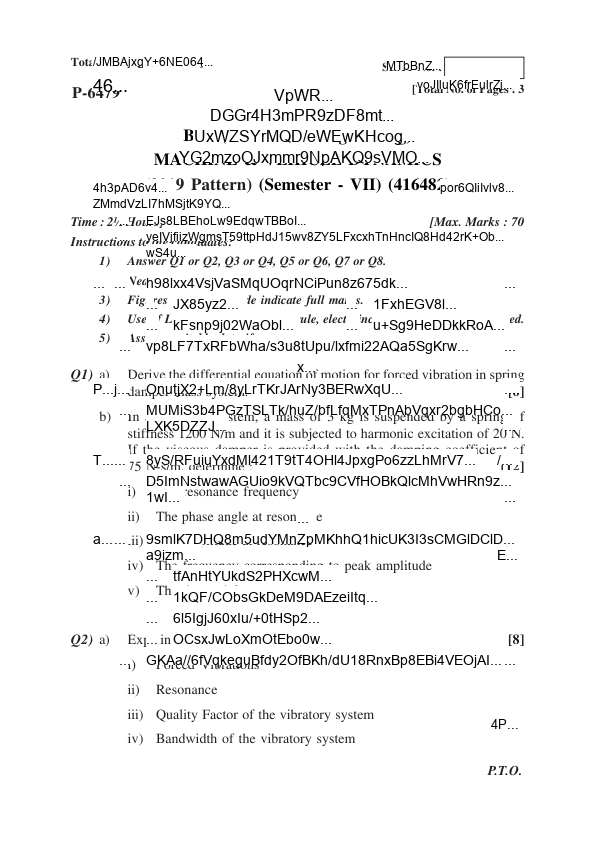

✅ Encrypted image saved: encrypted_output_accurate\encrypted_page_2.png


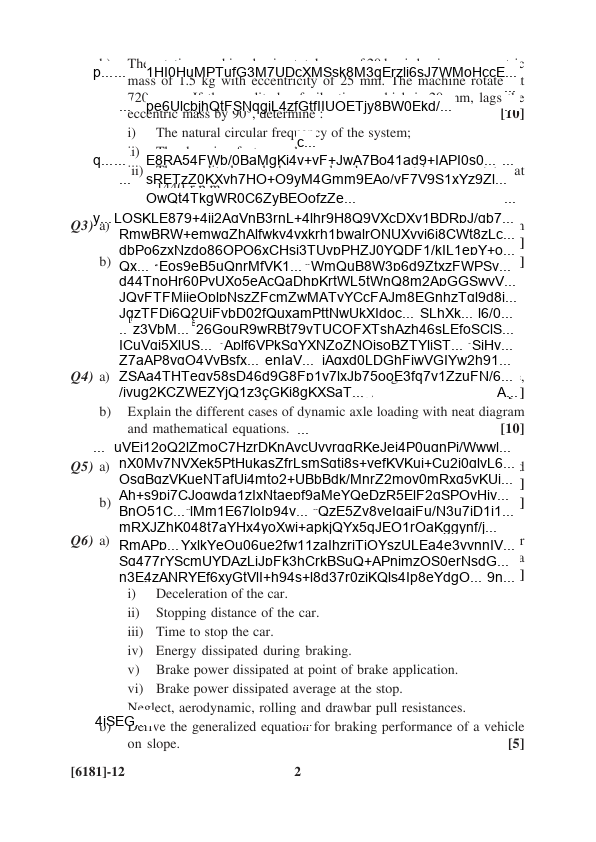


📝 Encrypted box data saved to: saved_boxes_with_encryption.json


In [25]:
replace_text_with_encrypted_images_accurate(
    pdf_path="question_paper_pdf_dataset_3_5.pdf",
    text_boxes=text_boxes,
    font_path="C:\\Windows\\Fonts\\arial.ttf"
)


In [9]:
import os
import img2pdf
from PIL import Image
from IPython.display import display, FileLink

def convert_encrypted_images_to_pdf(
    encrypted_images_dir="encrypted_output_accurate",
    output_pdf_path="encrypted_output.pdf"
):
    # Get all encrypted image files in the directory
    image_files = [
        os.path.join(encrypted_images_dir, f)
        for f in os.listdir(encrypted_images_dir)
        if f.endswith(".png") and f.startswith("encrypted_page_")
    ]
    
    # Sort files by page number
    image_files.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
    
    # Convert images to PDF
    with open(output_pdf_path, "wb") as pdf_file:
        pdf_file.write(img2pdf.convert(image_files))
    
    print(f"✅ Encrypted images converted to PDF: {output_pdf_path}")
    display(FileLink(output_pdf_path))

# Example usage
convert_encrypted_images_to_pdf()

✅ Encrypted images converted to PDF: encrypted_output.pdf


c:\Users\HP\Desktop\encryption_03\dataset\encrypted_output.pdf

In [20]:
import os
import base64
import json
from Crypto.Cipher import AES
from Crypto.Util.Padding import unpad
import hmac
import hashlib
import fitz  # PyMuPDF
from IPython.display import display, FileLink
from PIL import Image, ImageDraw, ImageFont

# Configuration
CONFIG = {
    "font_path": "arial.ttf",  # Default font (will try system fonts)
    "default_font_size": 10,
    "output_folder": "decrypted_output",
    "error_color": (1, 0, 0),  # Red for errors
    "success_color": (0, 0, 0),  # Black for success
    "background_color": (1, 1, 1)  # White background
}

def aes_decrypt(encrypted_data_base64, key_base64):
    """Decrypt data using AES-CBC with HMAC verification"""
    try:
        encrypted_data = base64.b64decode(encrypted_data_base64)
        iv = encrypted_data[:16]
        ciphertext = encrypted_data[16:-32]
        received_mac = encrypted_data[-32:]
        
        key_bytes = base64.b64decode(key_base64)
        key_hash = hashlib.sha256(key_bytes).digest()
        
        # Verify HMAC
        computed_mac = hmac.new(key_hash, iv + ciphertext, hashlib.sha256).digest()
        if not hmac.compare_digest(computed_mac, received_mac):
            raise ValueError("HMAC verification failed - possible tampering detected")
        
        cipher = AES.new(key_hash, AES.MODE_CBC, iv)
        decrypted_padded = cipher.decrypt(ciphertext)
        return unpad(decrypted_padded, AES.block_size).decode('utf-8')
    except Exception as e:
        raise ValueError(f"Decryption failed: {str(e)}")

def load_font(font_path, font_size):
    """Try to load font with fallbacks"""
    try:
        return ImageFont.truetype(font_path, font_size)
    except:
        try:
            return ImageFont.truetype("arial.ttf", font_size)
        except:
            return ImageFont.load_default()

def reconstruct_pdf_with_decrypted_text(original_pdf_path, json_file_path, key_base64):
    """Main function to reconstruct PDF with decrypted content"""
    # Setup output directory
    os.makedirs(CONFIG["output_folder"], exist_ok=True)
    output_pdf_path = os.path.join(CONFIG["output_folder"], "decrypted_document.pdf")
    log_file_path = os.path.join(CONFIG["output_folder"], "decryption_log.txt")
    
    # Initialize logging
    log_content = []
    
    try:
        original_pdf = fitz.open(original_pdf_path)
        new_pdf = fitz.open()
        
        with open(json_file_path, 'r', encoding='utf-8') as f:
            encrypted_data = json.load(f)
        
        for page_num, page_data in enumerate(encrypted_data):
            original_page = original_pdf[page_num]
            new_page = new_pdf.new_page(
                width=original_page.rect.width,
                height=original_page.rect.height
            )
            
            log_content.append(f"\nPage {page_num + 1}:")

            for box_idx, box_data in enumerate(page_data):
                x0, y0, x1, y1, encrypted_text, original_text = box_data
                rect = fitz.Rect(x0, y0, x1, y1)
                
                try:
                    decrypted_text = aes_decrypt(encrypted_text, key_base64)
                    match_status = decrypted_text == original_text
                    
                    # Add to log
                    log_entry = (
                        f"Box {box_idx + 1} - Position: {[x0, y0, x1, y1]}\n"
                        f"Original: {original_text}\n"
                        f"Decrypted: {decrypted_text}\n"
                        f"Status: {'MATCH' if match_status else 'MISMATCH'}\n"
                    )
                    log_content.append(log_entry)
                    
                    # Insert text into PDF
                    new_page.insert_textbox(
                        rect,
                        decrypted_text,
                        fontsize=CONFIG["default_font_size"],
                        fontname="helv",
                        color=CONFIG["success_color"],
                        align=0
                    )
                    
                except Exception as e:
                    error_msg = f"Box {box_idx + 1} - Decryption failed: {str(e)}"
                    log_content.append(error_msg)
                    new_page.insert_textbox(
                        rect,
                        "[DECRYPTION ERROR]",
                        fontsize=8,
                        color=CONFIG["error_color"]
                    )
        
        # Save the reconstructed PDF
        new_pdf.save(output_pdf_path)
        log_content.insert(0, f"PDF successfully saved to: {os.path.abspath(output_pdf_path)}")
        
        # Save log file
        with open(log_file_path, 'w', encoding='utf-8') as log_file:
            log_file.write("\n".join(log_content))
        
        print("\n".join(log_content[:5]))  # Print first 5 log entries
        print(f"\nFull log saved to: {os.path.abspath(log_file_path)}")
        
        # Display download link in Jupyter
        try:
            display(FileLink(output_pdf_path))
        except:
            print(f"Download PDF: file://{os.path.abspath(output_pdf_path)}")
        
        return output_pdf_path
        
    except Exception as e:
        error_msg = f"Critical error during PDF reconstruction: {str(e)}"
        log_content.append(error_msg)
        print(error_msg)
        with open(log_file_path, 'w', encoding='utf-8') as log_file:
            log_file.write("\n".join(log_content))
        return None
    finally:
        if 'original_pdf' in locals():
            original_pdf.close()
        if 'new_pdf' in locals():
            new_pdf.close()

# Example execution
if __name__ == "__main__":
    # User configuration - UPDATE THESE VALUES
    settings = {
        "original_pdf": "question_paper_pdf_dataset_3_5.pdf",
        "json_file": "saved_boxes_with_encryption.json",
        "encryption_key": "o9ZazGGUBRA/x4fkUCLNlw=="  # Replace with your actual key
    }
    
    # Run the reconstruction
    result_path = reconstruct_pdf_with_decrypted_text(
        original_pdf_path=settings["original_pdf"],
        json_file_path=settings["json_file"],
        key_base64=settings["encryption_key"]
    )
    
    if result_path:
        print(f"\n✅ Process completed successfully!")
        print(f"Decrypted PDF: {os.path.abspath(result_path)}")
    else:
        print("\n❌ Process failed - check log file for details")

PDF successfully saved to: c:\Users\HP\Desktop\encryption_03\dataset\decrypted_output\decrypted_document.pdf

Page 1:
Box 1 - Position: [70.8499984741211, 366.43603515625, 93.2863998413086, 382.3120422363281]
Original: Q1)
Decrypted: Q1)
Status: MATCH

Box 2 - Position: [93.2863998413086, 366.43603515625, 109.61320495605469, 382.3120422363281]
Original: a)
Decrypted: a)
Status: MATCH

Box 3 - Position: [127.61299896240234, 366.43603515625, 524.490234375, 382.3120422363281]
Original: Derive the differential equation of motion for forced vibration in spring
Decrypted: Derive the differential equation of motion for forced vibration in spring
Status: MATCH


Full log saved to: c:\Users\HP\Desktop\encryption_03\dataset\decrypted_output\decryption_log.txt


c:\Users\HP\Desktop\encryption_03\dataset\decrypted_output\decrypted_document.pdf


✅ Process completed successfully!
Decrypted PDF: c:\Users\HP\Desktop\encryption_03\dataset\decrypted_output\decrypted_document.pdf


In [ ]:
import os
import json
import base64
import fitz  # PyMuPDF
from PIL import Image, ImageDraw, ImageFont
from Crypto.Cipher import AES
from Crypto.Util.Padding import unpad
import hmac
import hashlib
import img2pdf

aes_key_base64 = " QWZPj7gFxAR3+3ps8KSq2Q=="  # Replace with your AES key

def aes_decrypt(encrypted_text, key_base64):
    try:
        key_bytes = base64.b64decode(key_base64)
        key_hash = hashlib.sha256(key_bytes).digest()
        raw = base64.b64decode(encrypted_text)
        iv = raw[:16]
        encrypted = raw[16:-32]
        mac = raw[-32:]

        expected_mac = hmac.new(key_hash, iv + encrypted, hashlib.sha256).digest()
        if not hmac.compare_digest(mac, expected_mac):
            raise ValueError("HMAC verification failed")

        cipher = AES.new(key_hash, AES.MODE_CBC, iv)
        decrypted = cipher.decrypt(encrypted)
        return unpad(decrypted, AES.block_size).decode("utf-8")
    except Exception as e:
        print(f"Decryption failed: {str(e)}")
        return "[DECRYPTION ERROR]"

def draw_wrapped_text(draw, text, box_x, box_y, box_width, box_height, font_path, min_font_size=8, padding=20):
    font_size = int(box_height * 0.7)  # Start smaller to ensure fit
    while font_size >= min_font_size:
        try:
            font = ImageFont.truetype(font_path, font_size)
        except:
            font = ImageFont.load_default()

        # Adjust box dimensions with padding
        padded_width = box_width - 2 * padding
        padded_height = box_height - 2 * padding

        # Split text into words and wrap lines
        words = text.split()
        lines = []
        current_line = ""
        
        for word in words:
            test_line = f"{current_line} {word}".strip()
            if draw.textlength(test_line, font=font) <= padded_width:
                current_line = test_line
            else:
                if current_line:
                    lines.append(current_line)
                current_line = word
        if current_line:
            lines.append(current_line)

        # Calculate total text height
        line_height = font.getbbox("A")[3] - font.getbbox("A")[1]
        total_height = len(lines) * line_height

        # Check if text fits or use minimum font size
        if total_height <= padded_height or font_size == min_font_size:
            return lines, font, line_height

        font_size -= 1  # Reduce font size and retry

    return lines, font, line_height

def decrypt_and_generate_clean_pdf(
    box_data_path="saved_boxes_with_encryption.json",
    encrypted_pdf_path="encrypted_output.pdf",
    output_pdf_path="clean_letter_decrypted_output.pdf",
    font_path="C:\\Windows\\Fonts\\arial.ttf",  # Windows Arial font
    dpi=300,
    padding=20  # Increased padding
):
    with open(box_data_path, "r", encoding="utf-8") as f:
        all_data = json.load(f)

    pdf_document = fitz.open(encrypted_pdf_path)

    temp_dir = "temp_clean_pages"
    os.makedirs(temp_dir, exist_ok=True)
    decrypted_images = []

    # LETTER size (8.5x11 inches) at 300 DPI
    letter_width_px = int(8.5 * dpi)
    letter_height_px = int(11 * dpi)

    for page_num, page_data in enumerate(all_data):
        if page_num >= len(pdf_document):
            break

        original_page = pdf_document[page_num]
        original_width = original_page.rect.width
        original_height = original_page.rect.height

        # Scale to fit LETTER size
        scale_x = letter_width_px / original_width
        scale_y = letter_height_px / original_height

        img = Image.new("RGB", (letter_width_px, letter_height_px), "white")
        draw = ImageDraw.Draw(img)

        for box_info in page_data:
            if len(box_info) >= 6:
                try:
                    x0, y0, x1, y1 = box_info[0], box_info[1], box_info[2], box_info[3]
                    encrypted_text = box_info[4]

                    decrypted_text = aes_decrypt(encrypted_text, aes_key_base64)

                    # Scale box coordinates
                    scaled_x0 = x0 * scale_x
                    scaled_y0 = y0 * scale_y
                    scaled_x1 = x1 * scale_x
                    scaled_y1 = y1 * scale_y
                    box_width = scaled_x1 - scaled_x0
                    box_height = scaled_y1 - scaled_y0

                    # Draw text with padding
                    lines, font, line_height = draw_wrapped_text(
                        draw, decrypted_text, scaled_x0, scaled_y0, box_width, box_height, font_path, padding=padding
                    )

                    for i, line in enumerate(lines):
                        text_x = scaled_x0 + padding
                        text_y = scaled_y0 + padding + i * line_height
                        draw.text((text_x, text_y), line, font=font, fill="black")

                except Exception as e:
                    print(f"Error on page {page_num + 1}: {str(e)}")

        # Save page as PNG
        temp_path = os.path.join(temp_dir, f"letter_page_{page_num + 1}.png")
        img.save(temp_path, dpi=(dpi, dpi))
        decrypted_images.append(temp_path)
        print(f"✅ Processed page {page_num + 1}")

    # Convert PNGs to PDF
    with open(output_pdf_path, "wb") as pdf_file:
        pdf_file.write(img2pdf.convert(decrypted_images))

    # Cleanup
    for img_path in decrypted_images:
        os.remove(img_path)
    os.rmdir(temp_dir)

    print(f"\n✅ Decrypted PDF saved to: {output_pdf_path}")

# Run the decryption
decrypt_and_generate_clean_pdf()

✅ Processed page 1
✅ Processed page 2
✅ Processed page 3

✅ Decrypted PDF saved to: clean_letter_decrypted_output.pdf


✅ Decrypted image saved: decrypted_output\decrypted_page_1.png


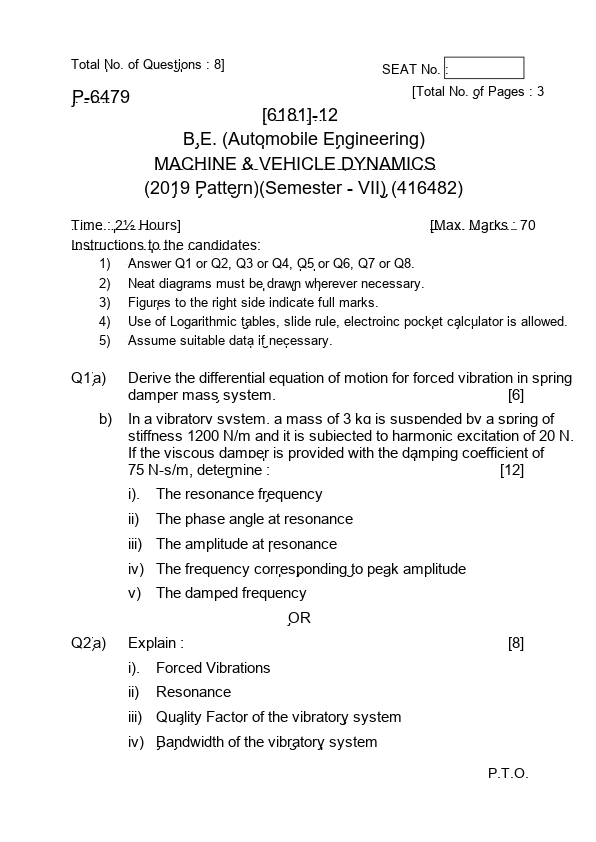

✅ Decrypted image saved: decrypted_output\decrypted_page_2.png


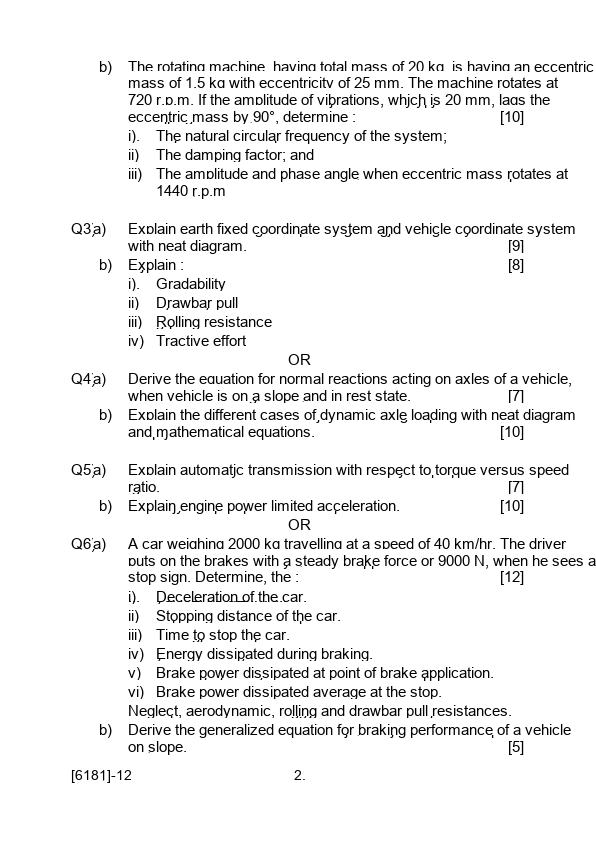

✅ Decrypted image saved: decrypted_output\decrypted_page_3.png


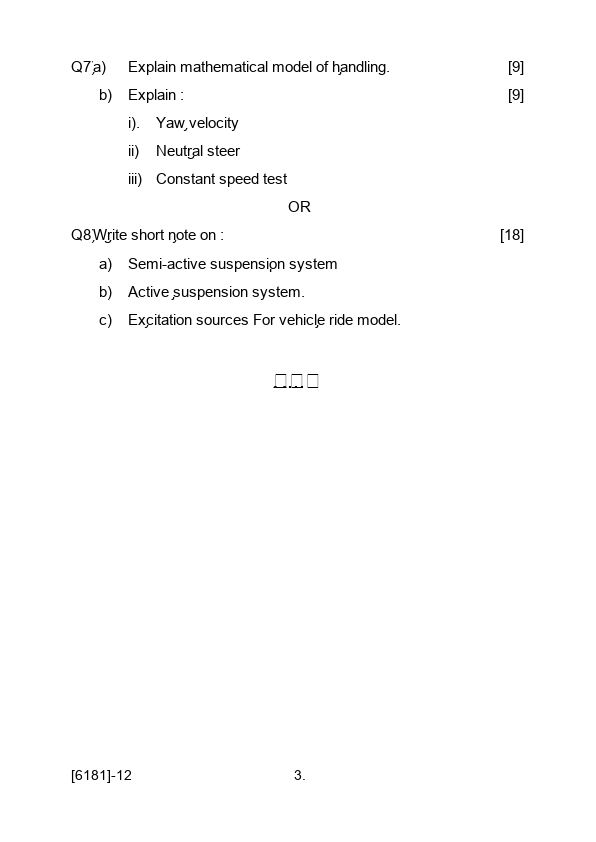

In [ ]:
# import os
# import json
# import base64
# from PIL import Image, ImageDraw, ImageFont
# from Crypto.Cipher import AES
# from Crypto.Util.Padding import unpad
# import hmac
# import hashlib

# # Your saved AES key from encryption
# aes_key_base64 = "V/+3mGEGmXo9z2Dgtqkz9w=="  # Replace this with your actual key

# # 🔓 AES decryption with HMAC verification
# def aes_decrypt(encrypted_text, key_base64):
#     key_bytes = base64.b64decode(key_base64)
#     key_hash = hashlib.sha256(key_bytes).digest()

#     raw = base64.b64decode(encrypted_text)
#     iv = raw[:16]
#     encrypted = raw[16:-32]
#     mac = raw[-32:]

#     # HMAC check
#     expected_mac = hmac.new(key_hash, iv + encrypted, hashlib.sha256).digest()
#     if not hmac.compare_digest(mac, expected_mac):
#         raise ValueError("⚠️ HMAC verification failed: data may be tampered.")

#     cipher = AES.new(key_hash, AES.MODE_CBC, iv)
#     decrypted = cipher.decrypt(encrypted)
#     return unpad(decrypted, AES.block_size).decode("utf-8")

# # Draw text centered inside the box
# def draw_text_in_box(draw, text, box, font, fill="black"):
#     x0, y0, x1, y1 = box
#     box_height = y1 - y0
#     text_bbox = font.getbbox("A")
#     text_height = text_bbox[3] - text_bbox[1]
#     y_centered = y0 + (box_height - text_height) / 2
#     draw.text((x0, y_centered), text, font=font, fill=fill)

# # 🔁 Decrypt and restore text to images
# def decrypt_and_restore_images(
#     box_data_path,
#     encrypted_img_dir,
#     output_dir="decrypted_output",
#     font_path="C:\\Windows\\Fonts\\arial.ttf"
# ):
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     key_base64 = aes_key_base64
#     with open(box_data_path, "r", encoding="utf-8") as f:
#         all_data = json.load(f)

#     for page_num, page_data in enumerate(all_data):
#         img_path = os.path.join(encrypted_img_dir, f"encrypted_page_{page_num + 1}.png")
#         if not os.path.exists(img_path):
#             print(f"❌ Image not found: {img_path}")
#             continue

#         img = Image.open(img_path)
#         draw = ImageDraw.Draw(img)

#         for x0, y0, x1, y1, encrypted_text, original_text in page_data:
#             try:
#                 decrypted = aes_decrypt(encrypted_text, key_base64)
#             except Exception as e:
#                 print(f"⚠️ Decryption error: {e}")
#                 decrypted = "[Decryption Error]"

#             box_width = x1 - x0
#             box_height = y1 - y0
#             font_size = max(8, int(box_height))
#             font = ImageFont.truetype(font_path, font_size)

#             draw.rectangle([x0, y0, x1, y1], fill="white")
#             draw_text_in_box(draw, decrypted, (x0, y0, x1, y1), font)

#         output_path = os.path.join(output_dir, f"decrypted_page_{page_num + 1}.png")
#         img.save(output_path)
#         print(f"✅ Decrypted image saved: {output_path}")
#         display(img)
        

# # ✅ Run the function
# decrypt_and_restore_images(
#     box_data_path="saved_boxes_with_encryption.json",
#     encrypted_img_dir="encrypted_output_accurate",
#     output_dir="decrypted_output"
# )


In [2]:
from PIL import Image
import os

def images_to_pdf(image_dir, output_pdf_path):
    image_files = sorted(
        [f for f in os.listdir(image_dir) if f.endswith(".png")],
        key=lambda x: int(x.split("_")[-1].split(".")[0])  # Sort by page number
    )

    if not image_files:
        print("❌ No images found in the directory.")
        return

    image_paths = [os.path.join(image_dir, img) for img in image_files]
    images = [Image.open(img_path).convert("RGB") for img_path in image_paths]

    first_image = images[0]
    remaining_images = images[1:]

    output_pdf_path = output_pdf_path if output_pdf_path.endswith(".pdf") else output_pdf_path + ".pdf"
    first_image.save(output_pdf_path, save_all=True, append_images=remaining_images)

    print(f"📄 Decrypted PDF saved as: {output_pdf_path}")

# ✅ Convert decrypted images to PDF
images_to_pdf(
    image_dir="decrypted_output",
    output_pdf_path="decrypted_question_paper.pdf"
)


📄 Decrypted PDF saved as: decrypted_question_paper.pdf
